In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
# 파일 경로 설정
train_files = ['Data/train_data20231.csv', 'Data/train_data20232.csv', 'Data/train_data20233.csv']
validation_file = 'Data/train_data20234.csv'
test_file = 'Data/train_data20242.csv'

# Train 데이터 로드 및 통합
train_dfs = [pd.read_csv(file) for file in train_files]
train_data = pd.concat(train_dfs, ignore_index=True)

# Validation 데이터 로드
validation_data = pd.read_csv(validation_file)

# Test 데이터 로드
test_data = pd.read_csv(test_file)

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수']

X_train = train_data[features]
X_val = validation_data[features]
X_test = test_data[features]



In [5]:
# 2. 매출액을 3개의 구간으로 나누기 (저매출, 중매출, 고매출)
bins = [0, 1e8, 1.5e8, np.inf]  # 구간 설정: 1억 원 이하, 1억~1.5억 원, 1.5억 원 이상
labels = ['Low', 'Medium', 'High']  # 구간 라벨 설정

# Train 데이터에 매출 구간화 적용
y_train_binned = pd.cut(train_data['money'], bins=bins, labels=labels)

# Validation 데이터에 매출 구간화 적용
y_val_binned = pd.cut(validation_data['money'], bins=bins, labels=labels)

# Test 데이터에 매출 구간화 적용
y_test_binned = pd.cut(test_data['money'], bins=bins, labels=labels)



In [6]:
# 3. Gradient Boosting Classifier 모델 학습 (분류 문제로 변환)
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train, y_train_binned)





GradientBoostingClassifier(random_state=42)

In [7]:
# 4. 검증 데이터로 예측 및 평가
y_val_pred = gbm_model.predict(X_val)
val_accuracy = accuracy_score(y_val_binned, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val_binned, y_val_pred))


Validation Accuracy: 0.6939639957642075
Validation Classification Report:
               precision    recall  f1-score   support

        High       0.77      0.62      0.69      1958
         Low       0.77      0.48      0.59      2365
      Medium       0.65      0.85      0.74      4176

    accuracy                           0.69      8499
   macro avg       0.73      0.65      0.67      8499
weighted avg       0.71      0.69      0.69      8499



In [8]:
# 5. 테스트 데이터로 예측 및 평가
y_test_pred = gbm_model.predict(X_test)
test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_test_binned, y_test_pred))



Test Accuracy: 0.6825508883398047
Test Classification Report:
               precision    recall  f1-score   support

        High       0.78      0.58      0.66      2176
         Low       0.73      0.51      0.60      2254
      Medium       0.64      0.84      0.72      4069

    accuracy                           0.68      8499
   macro avg       0.72      0.64      0.66      8499
weighted avg       0.70      0.68      0.68      8499



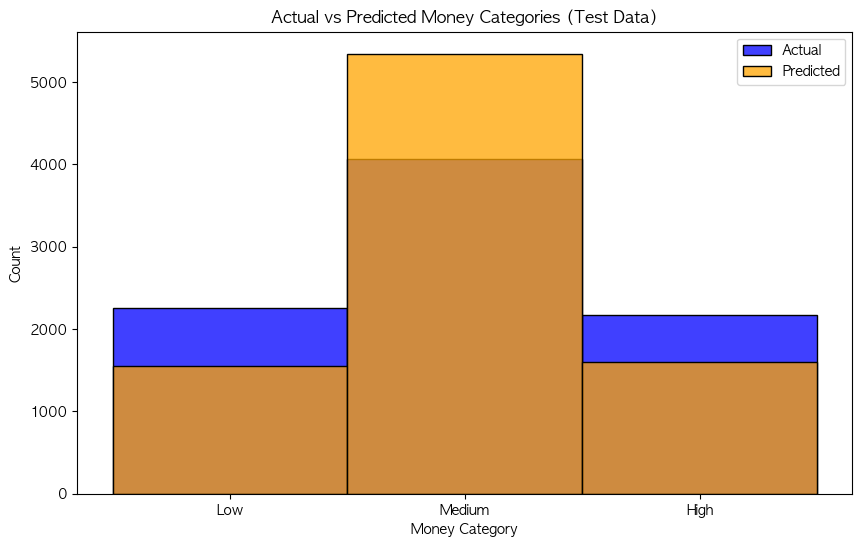

In [9]:
# 6. 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
sns.histplot(y_test_binned, color='blue', label='Actual', kde=False)
sns.histplot(y_test_pred, color='orange', label='Predicted', kde=False)
plt.title("Actual vs Predicted Money Categories (Test Data)")
plt.xlabel("Money Category")
plt.ylabel("Count")
plt.legend()
plt.show()

-----

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리 (쿼터 변수 포함)
train_files = ['Data/train_data20231.csv', 'Data/train_data20232.csv', 'Data/train_data20233.csv']
validation_file = 'Data/train_data20234.csv'
test_file = 'Data/train_data20242.csv'

# Train 데이터 로드 및 통합 + 쿼터 정보 추가
train_dfs = []
for file in train_files:
    df = pd.read_csv(file)
    quarter_str = file.split('_')[-1].split('.')[0]  # 파일명에서 분기 정보 추출 (예: 'data20231')
    quarter_num = int(quarter_str.replace('data', ''))  # 'data20231' -> 20231 (숫자형으로 변환)
    df['quarter'] = quarter_num  # 숫자형 쿼터 정보를 새로운 열로 추가
    train_dfs.append(df)

train_data = pd.concat(train_dfs, ignore_index=True)

# Validation 데이터 로드 + 쿼터 정보 추가
validation_data = pd.read_csv(validation_file)
validation_quarter_str = validation_file.split('_')[-1].split('.')[0]
validation_quarter_num = int(validation_quarter_str.replace('data', ''))
validation_data['quarter'] = validation_quarter_num

# Test 데이터 로드 + 쿼터 정보 추가
test_data = pd.read_csv(test_file)
test_quarter_str = test_file.split('_')[-1].split('.')[0]
test_quarter_num = int(test_quarter_str.replace('data', ''))
test_data['quarter'] = test_quarter_num

# 필요한 열만 선택 (유동인구, 직장인구, 쿼터 변수 포함)
features = ['10대_유동인구수', '20대_유동인구수', '30대_유동인구수', 
            '40대_유동인구수', '50대_유동인구수', '60대_이상_유동인구수',
            '10대_직장인구수', '20대_직장인구수', '30대_직장인구수',
            '40대_직장인구수', '50대_직장인구수', '60대_이상_직장인구수',
            'quarter']  # 쿼터 변수 추가 (숫자형)

X_train = train_data[features]
X_val = validation_data[features]
X_test = test_data[features]


In [21]:
# 2. 매출액을 3개의 구간으로 나누기 (저매출, 중매출, 고매출)
bins = [0, 1e8, 1.5e8, np.inf]  # 구간 설정: 1억 원 이하, 1억~1.5억 원, 1.5억 원 이상
labels = ['Low', 'Medium', 'High']  # 구간 라벨 설정

# Train 데이터에 매출 구간화 적용
y_train_binned = pd.cut(train_data['money'], bins=bins, labels=labels)

# Validation 데이터에 매출 구간화 적용
y_val_binned = pd.cut(validation_data['money'], bins=bins, labels=labels)

# Test 데이터에 매출 구간화 적용
y_test_binned = pd.cut(test_data['money'], bins=bins, labels=labels)


plt.show()


In [22]:
# 3. 하이퍼파라미터 그리드 설정 및 Grid Search 실행 (GBM 모델)
param_grid = {
    'n_estimators': [100, 200],       # 더 많은 반복 횟수를 위해 n_estimators 값 증가 가능
    'learning_rate': [0.01, 0.1],     # 다양한 learning rate 시도
    'max_depth': [3, 4]               # 트리 깊이를 조정하여 복잡도 조절
}

gbm_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)  # cv=5로 교차 검증 횟수 증가

# Grid Search 실행 (Train 데이터 사용)
grid_search.fit(X_train, y_train_binned)

# 최적의 하이퍼파라미터 확인
print('Best Hyperparameters:', grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [23]:
# 최적의 모델로 검증 데이터 예측 및 평가
best_gbm_model = grid_search.best_estimator_
y_val_pred = best_gbm_model.predict(X_val)
val_accuracy = accuracy_score(y_val_binned, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val_binned, y_val_pred))



Validation Accuracy: 0.7590304741734322
Validation Classification Report:
               precision    recall  f1-score   support

        High       0.73      0.83      0.78      1958
         Low       0.92      0.57      0.70      2365
      Medium       0.73      0.83      0.78      4176

    accuracy                           0.76      8499
   macro avg       0.79      0.74      0.75      8499
weighted avg       0.78      0.76      0.75      8499



Test Accuracy: 0.7553829862336745
Test Classification Report:
               precision    recall  f1-score   support

        High       0.76      0.79      0.77      2176
         Low       0.88      0.58      0.70      2254
      Medium       0.71      0.84      0.77      4069

    accuracy                           0.76      8499
   macro avg       0.79      0.73      0.75      8499
weighted avg       0.77      0.76      0.75      8499



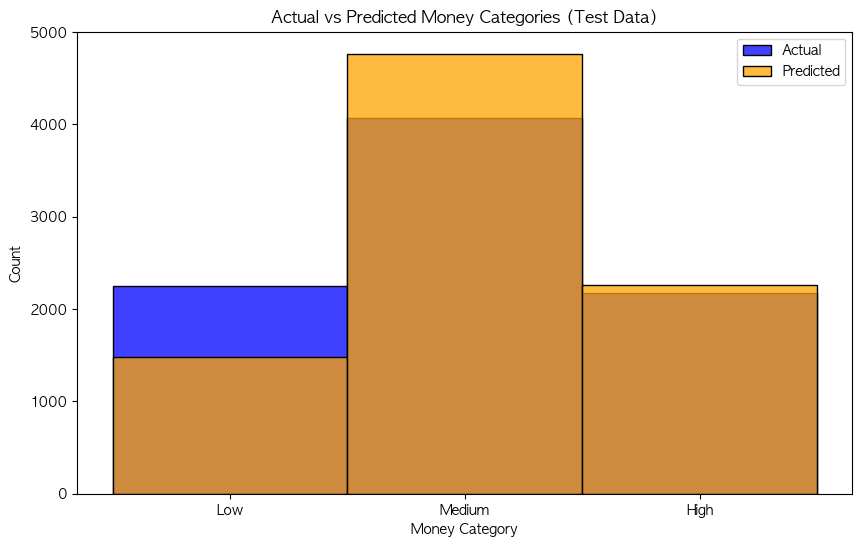

In [24]:
# 테스트 데이터로 예측 및 평가
y_test_pred = best_gbm_model.predict(X_test)
test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_test_binned, y_test_pred))

# 시각화 - 실제 값과 예측 값 비교 (테스트 데이터)
plt.figure(figsize=(10,6))
sns.histplot(y_test_binned, color='blue', label='Actual', kde=False)
sns.histplot(y_test_pred, color='orange', label='Predicted', kde=False)
plt.title("Actual vs Predicted Money Categories (Test Data)")
plt.xlabel("Money Category")
plt.ylabel("Count")
plt.legend()
plt.show()